In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import requests
from operator import itemgetter


In [2]:
def lastfm_request(api_method,artist='',track=''):
    
    if api_method==0:
        method = f"track.gettoptags&artist={artist}&track={track}"
    elif api_method==1:
        method = f"track.search&track={track}&limit=1"
    else:
        method = "geo.gettoptracks&country=Brazil&limit=50"
    
    key ="3dc1e72157f70010ef87db6b769fbfe7"
    API_URL = f'http://ws.audioscrobbler.com/2.0/?method={method}&api_key={key}&format=json'
    return requests.request(method='get', url=API_URL).json()

In [3]:
top_tracks = lastfm_request(2)['tracks']['track']
songs_graph = {}
songs_list = []
tags_list = []
for track in top_tracks:
    tags = lastfm_request(0,track["artist"]["name"],track["name"])['toptags']['tag'][:3]
    if track["name"] not in songs_graph:
        songs_list.append(track["name"])
        songs_graph[track["name"]] = []
        for tag in tags:
            songs_graph[track["name"]].append(tag["name"])
            if tag["name"] not in songs_graph:
                tags_list.append(tag["name"])
                songs_graph[tag["name"]] = [track["name"]]
            else:
                songs_graph[tag["name"]].append(track["name"])
print(songs_graph) 
print(songs_list)
print(tags_list)

{'Do I Wanna Know?': ['indie rock', 'indie', 'alternative'], 'indie rock': ['Do I Wanna Know?', 'Mr. Brightside', 'R U Mine?', 'Take Me Out', 'Fluorescent Adolescent', 'Last Nite', 'Sex on Fire', 'Reptilia', 'Somebody Told Me', "Why'd You Only Call Me When You're High?"], 'indie': ['Do I Wanna Know?', 'Mr. Brightside', 'R U Mine?', 'Pumped Up Kicks', 'The Less I Know the Better', 'Take Me Out', 'Fluorescent Adolescent', 'Last Nite', 'Royals', 'Reptilia', 'Somebody Told Me', 'Dog Days Are Over', "Why'd You Only Call Me When You're High?", 'Kids', 'Stressed Out'], 'alternative': ['Do I Wanna Know?', 'Losing My Religion', 'Seven Nation Army', 'The Less I Know the Better', 'Creep', 'Californication', 'Under the Bridge', 'Sex on Fire', 'Dog Days Are Over', 'Kids', 'Everlong', 'The Scientist', 'Scar Tissue', 'Feel Good Inc.', 'Stressed Out'], 'Mr. Brightside': ['rock', 'indie', 'indie rock'], 'rock': ['Mr. Brightside', 'Losing My Religion', 'Seven Nation Army', 'Smells Like Teen Spirit', 'Ta

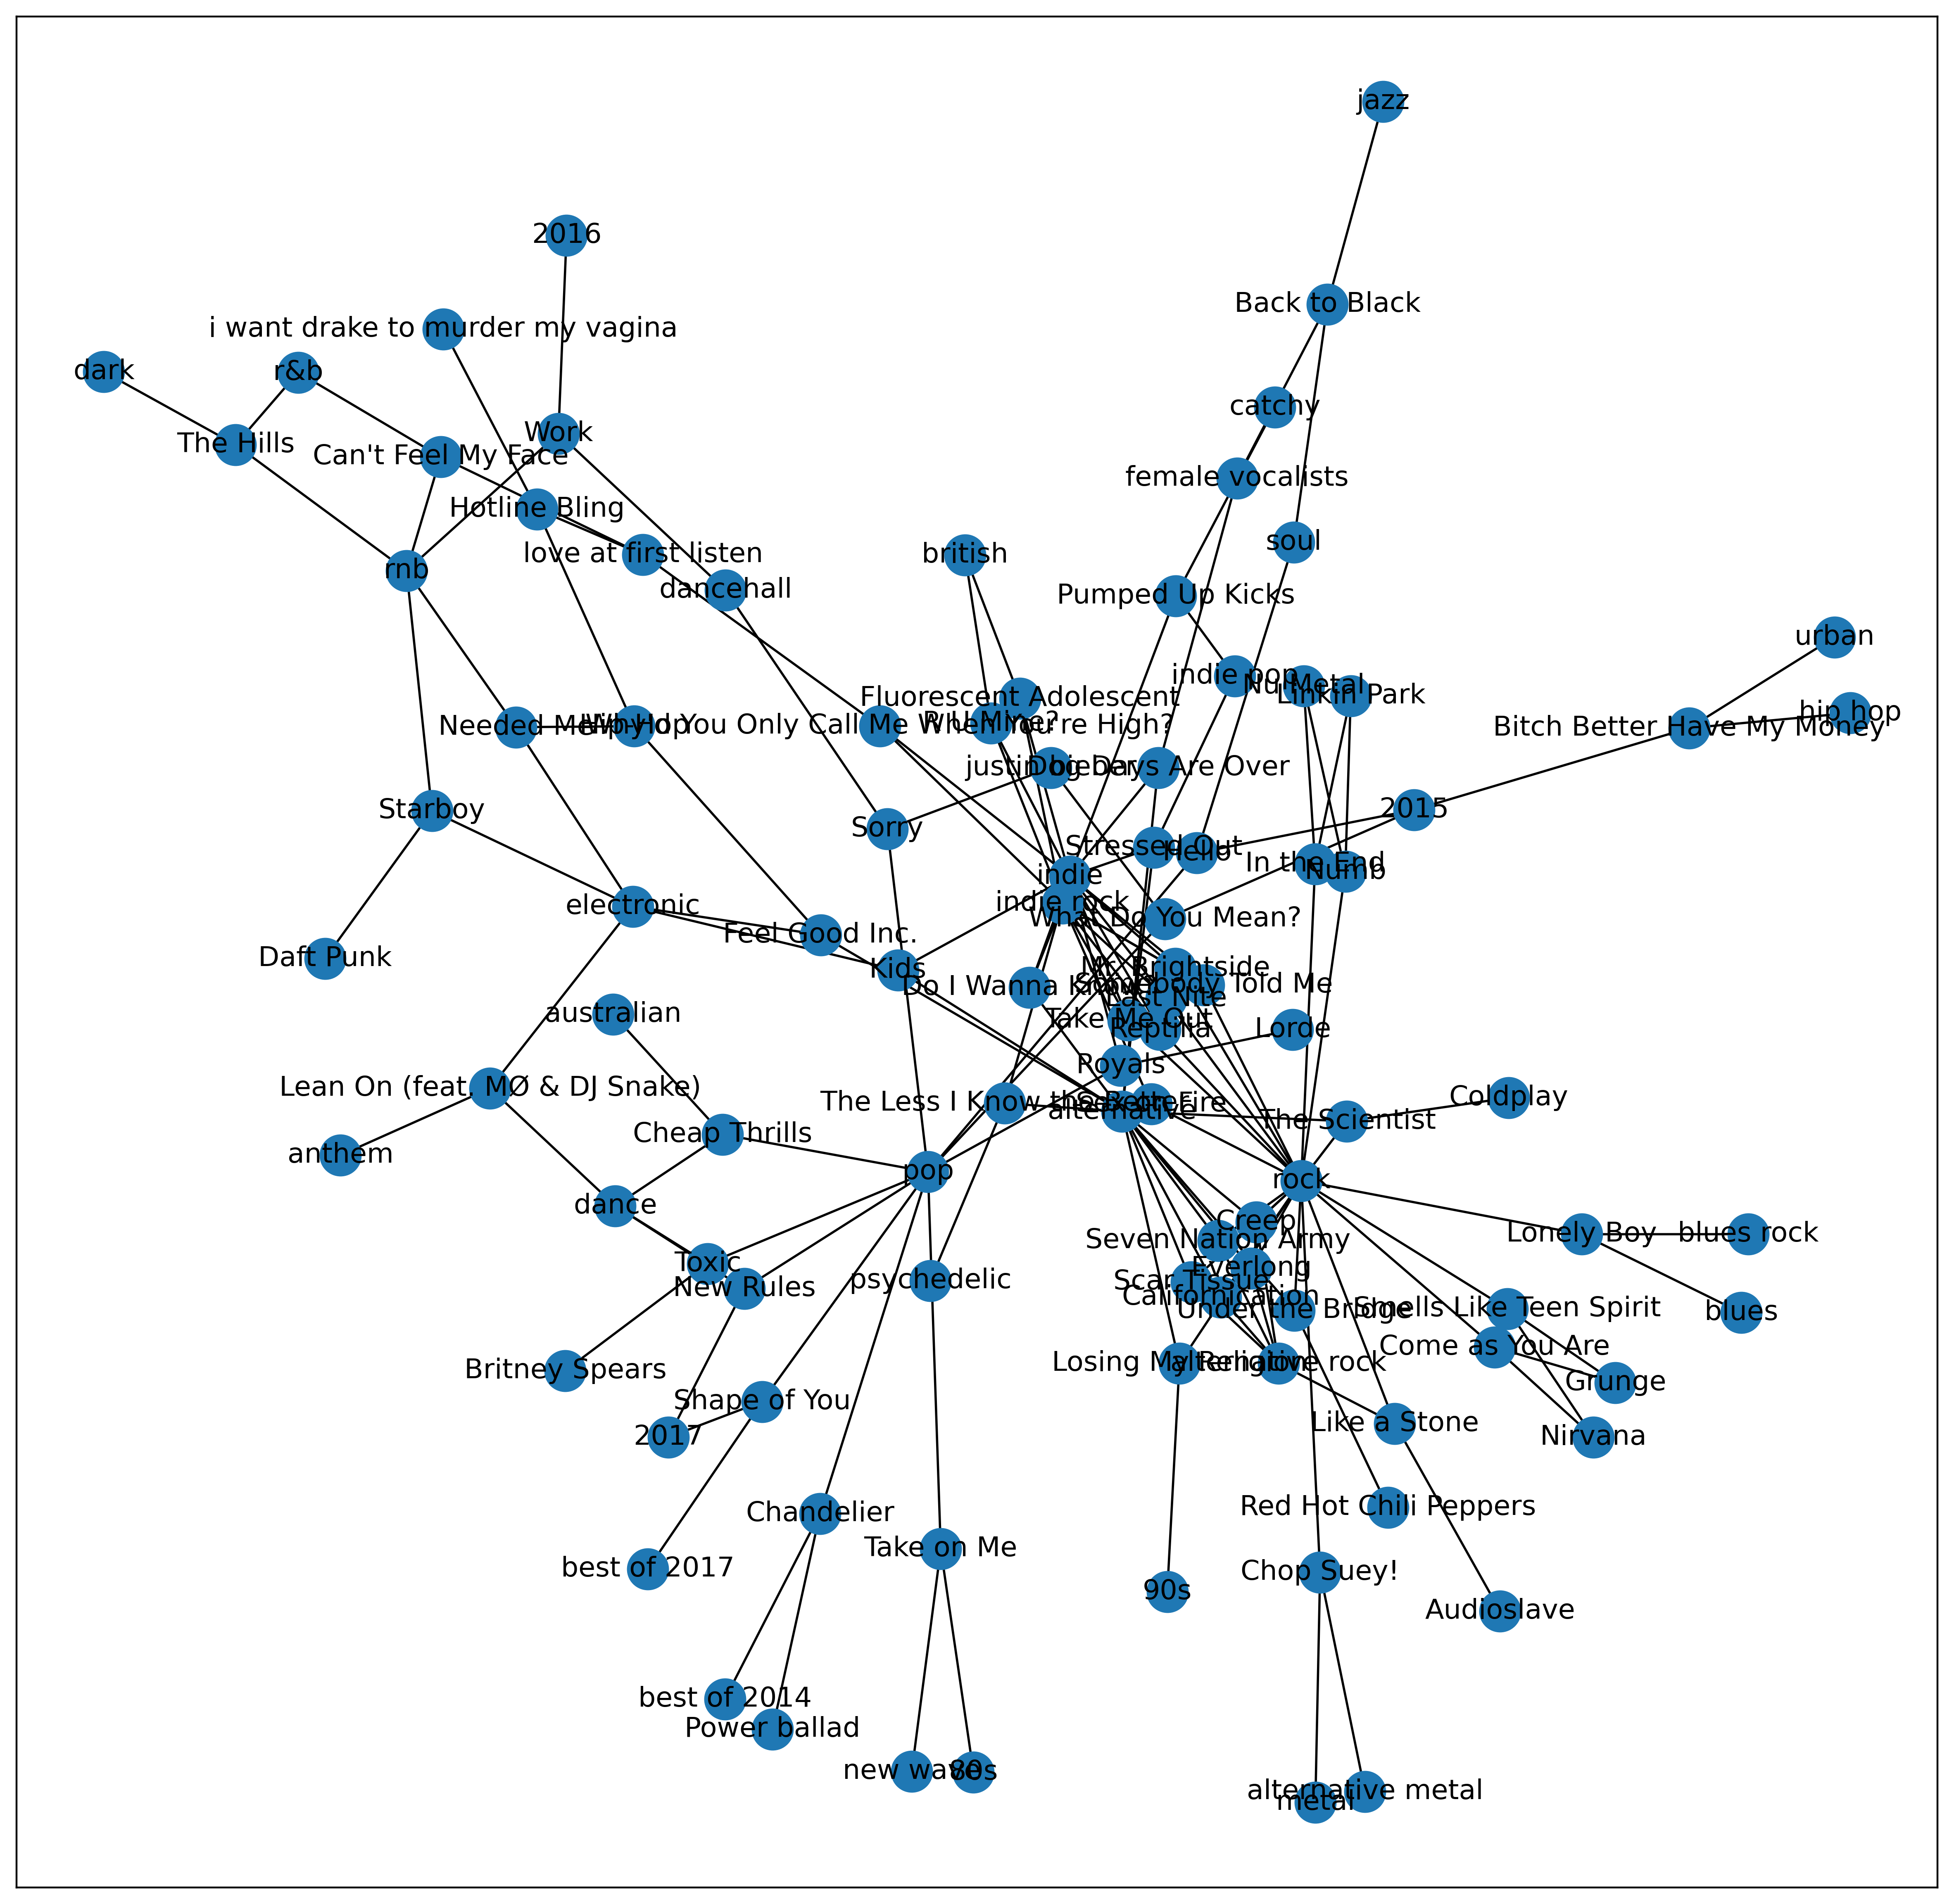

In [5]:
_graph = nx.Graph()

_graph.add_nodes_from(list(songs_graph.keys()))

for node in list(songs_graph.keys()):
    for edge in songs_graph[node]:
        _graph.add_edge(node,edge)
        
plt.figure(num=1,figsize=(15,15),dpi=400)

nx.draw_networkx(_graph)
plt.show()

In [4]:
def is_bipartide(G, start):

    if start not in G:
        return False
    
    level = 0  
    nextlevel = [start]  
    explored = {start: level}  
    while nextlevel:
        level = level + 1
        thislevel = nextlevel
        nextlevel = []
        for v in thislevel:
            for w in G[v]:
                if w not in explored:
                    explored[w] = level
                    nextlevel.append(w)
                elif explored[w] == explored[v]:
                    return False

    return True
is_bipartide(songs_graph, 'Do I Wanna Know?')

True

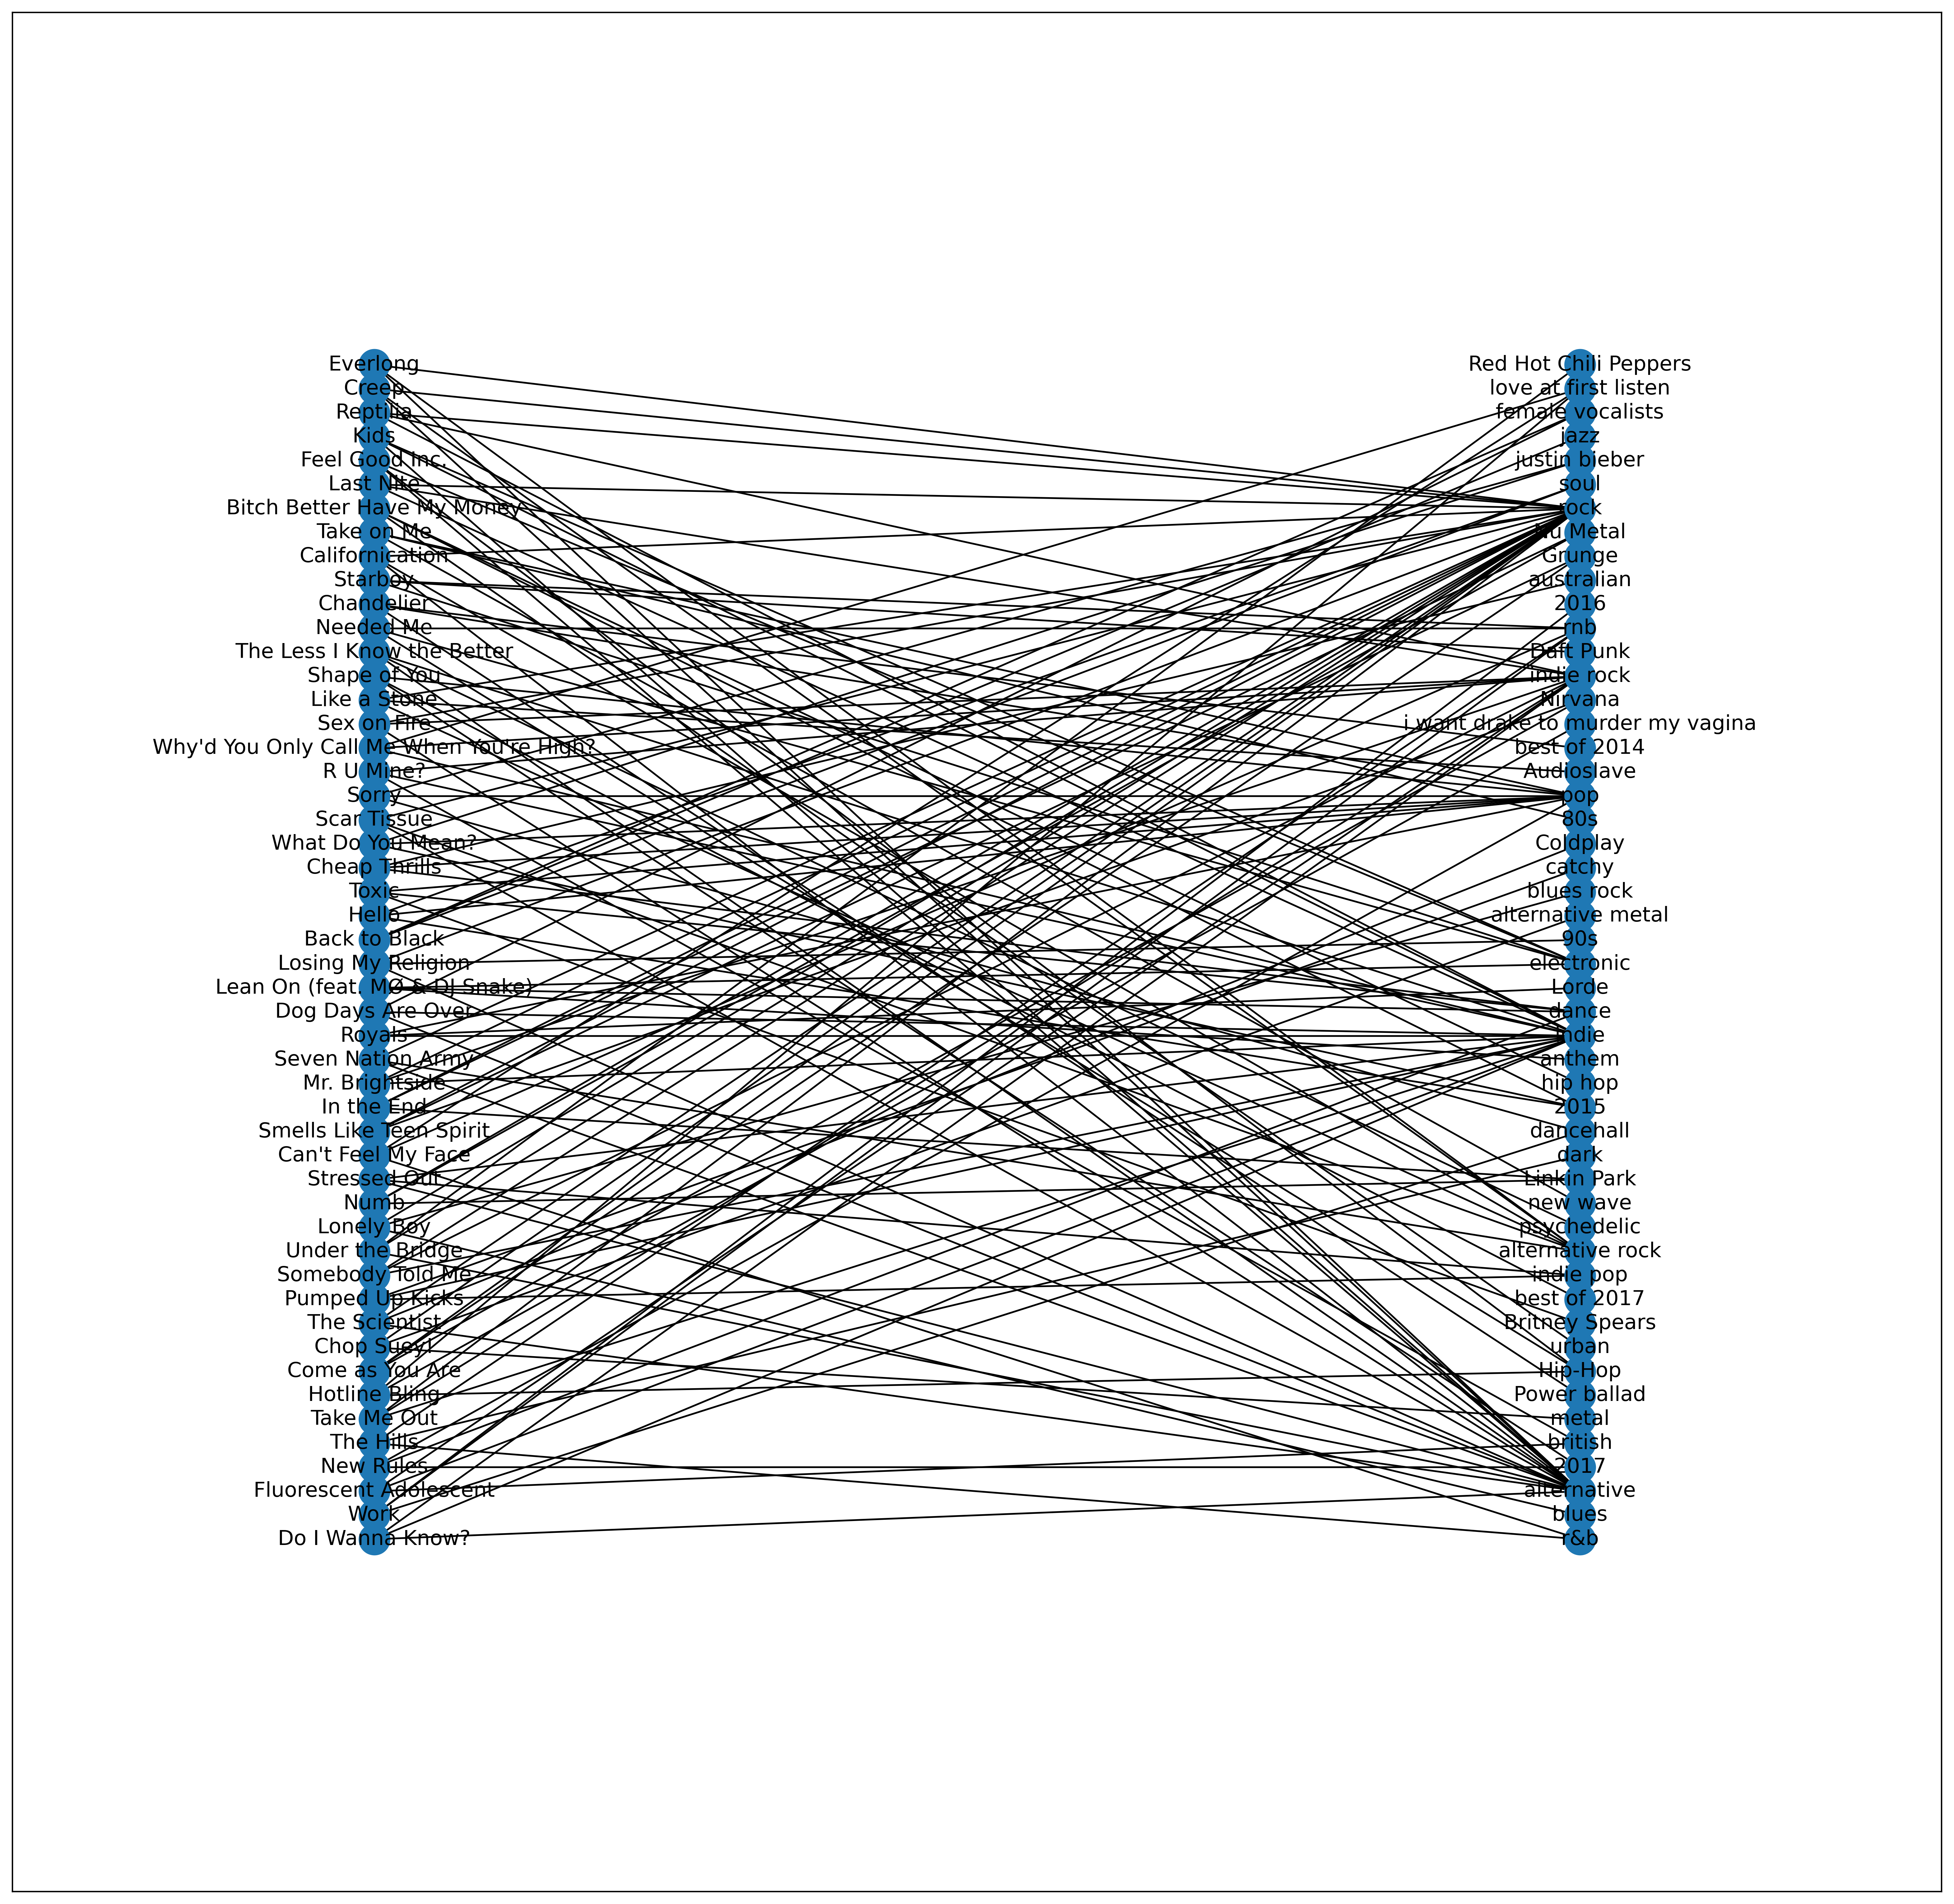

In [8]:
plt.figure(num=1,figsize=(20,20),dpi=400)
plt.margins(0.3)
nx.draw_networkx(
    _graph,
    pos = nx.drawing.layout.bipartite_layout(_graph, songs_list))
plt.show()

In [5]:
while True:
    song_name = input("Diga uma música que você gosta")
    result = lastfm_request(1,track=song_name)
    if result['results']['trackmatches']['track'] != []:
        break
    print('Musica nao encontrada, tente outra por favor')
        

result = result['results']['trackmatches']['track'][0]

print(f"Resultado: {result['name']} de {result['artist']}")

tags = lastfm_request(0,result['artist'],result['name'])['toptags']['tag'][:3]

if result['name'] not in songs_graph:
        songs_graph[result['name']] = []
        songs_list.append(result['name'])
        for tag in tags:
            songs_graph[result["name"]].append(tag["name"])
            if tag["name"] not in songs_graph:
                tags_list.append(tag["name"])
                songs_graph[tag["name"]] = [result["name"]]
            else:
                songs_graph[tag["name"]].append(result["name"])
                


Diga uma música que você gostapop stars
Resultado: POP/STARS de K/DA


In [ ]:
%%time
def dfs_caminhos(grafo, inicio, fim):
    pilha = [(inicio, [inicio])]
    depth = 0
    while pilha:
        vertice, caminho = pilha.pop()
        for proximo in set(grafo[vertice]) - set(caminho):
            if proximo == fim:
                yield caminho + [proximo]
            else:
                pilha.append((proximo, caminho + [proximo]))


best_matches = []
for node in songs_list:
    answers = [len(x) for x in list(dfs_caminhos(songs_graph, node, result['name']))]

    if answers:
        num_paths = answers.count(min(answers))
        path_lenght = min(answers)
        if path_lenght <=5:
            best_matches.append({'name':node,'lenght':path_lenght,'number':num_paths})

best_matches = sorted(best_matches, key=lambda k: (k['lenght'], -k['number']))
best_matches

In [8]:
%%time
def predecessor(G, start):

    if start not in G:
        raise False

    level = 0  
    nextlevel = [start]  
    explored = {start: level}  
    pred = {start: []}  
    while nextlevel:
        level = level + 1
        thislevel = nextlevel
        nextlevel = []
        for v in thislevel:
            for w in G[v]:
                if w not in explored:
                    pred[w] = [v]
                    explored[w] = level
                    nextlevel.append(w)
                elif explored[w] == level:  
                    pred[w].append(v)  

    return pred

def find_paths(start, target, pred):

    if target not in pred or {target}==start:
        return None

    explored = {target}
    stack = [[target, 0]]
    top = 0
    while top >= 0:
        node, i = stack[top]
        if node in start:
            yield [p for p, n in reversed(stack[: top + 1])]
        if len(pred[node]) > i:
            stack[top][1] = i + 1
            next = pred[node][i]
            if next in explored:
                continue
            else:
                explored.add(next)
            top += 1
            if top == len(stack):
                stack.append([next, 0])
            else:
                stack[top][:] = [next, 0]
        else:
            explored.discard(node)
            top -= 1


best_matches = []

for node in songs_list:
    parentage = predecessor(songs_graph, node)
    paths = list(find_paths({node}, result['name'], parentage))
    if paths != []:
        num_paths = len(paths)
        path_lenght = len(paths[0])
        if path_lenght <=5:
            best_matches.append({'name':node,'lenght':path_lenght,'number':num_paths})

best_matches = sorted(best_matches, key=lambda k: (k['lenght'], -k['number']))
best_matches

    

CPU times: user 4.15 ms, sys: 2.19 ms, total: 6.33 ms
Wall time: 6.01 ms


[{'name': 'Take on Me', 'lenght': 3, 'number': 1},
 {'name': 'Sorry', 'lenght': 3, 'number': 1},
 {'name': 'Chandelier', 'lenght': 3, 'number': 1},
 {'name': 'Royals', 'lenght': 3, 'number': 1},
 {'name': 'Hello', 'lenght': 3, 'number': 1},
 {'name': 'Toxic', 'lenght': 3, 'number': 1},
 {'name': 'Cheap Thrills', 'lenght': 3, 'number': 1},
 {'name': 'Shape of You', 'lenght': 3, 'number': 1},
 {'name': 'New Rules', 'lenght': 3, 'number': 1},
 {'name': 'What Do You Mean?', 'lenght': 3, 'number': 1},
 {'name': 'Lean On (feat. MØ & DJ Snake)', 'lenght': 5, 'number': 3},
 {'name': 'Bitch Better Have My Money', 'lenght': 5, 'number': 2},
 {'name': 'Do I Wanna Know?', 'lenght': 5, 'number': 1},
 {'name': 'Mr. Brightside', 'lenght': 5, 'number': 1},
 {'name': 'R U Mine?', 'lenght': 5, 'number': 1},
 {'name': 'Pumped Up Kicks', 'lenght': 5, 'number': 1},
 {'name': 'The Less I Know the Better', 'lenght': 5, 'number': 1},
 {'name': 'Take Me Out', 'lenght': 5, 'number': 1},
 {'name': 'Work', 'lengh

In [9]:
from IPython.core.display import display, HTML
display(HTML('<h1>Hello, world!</h1>'))